# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook I have trained the custom CNN and got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
##  Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


In [2]:
!pip install timm

In [ ]:
import timm
timm.list_models(pretrained=True)

---
## Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [5]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-7.1.1, pluggy-1.0.0 -- /usr/bin/python3.9
cachedir: .pytest_cache
rootdir: /notebooks
plugins: anyio-3.6.2
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

=============================== warnings summary ===============================
../usr/local/lib/python3.9/dist-packages/torchvision/transforms/_functional_pil.py:242
  /usr/local/lib/python3.9/dist-packages/torchvision/transforms/_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
    interpolation: int = Image.BILINEAR,

../usr/local/lib/python3.9/dist-packages/torchvision/transforms/_functional_pil.py:286
  /usr/local/lib/python3.9/dist-packages/torchvision/transforms/_functional_pil.py:286: DeprecationWar

---
## Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [5]:
batch_size = 32  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 10  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.0001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 5e-2 # regularization. Increase this to combat overfitting

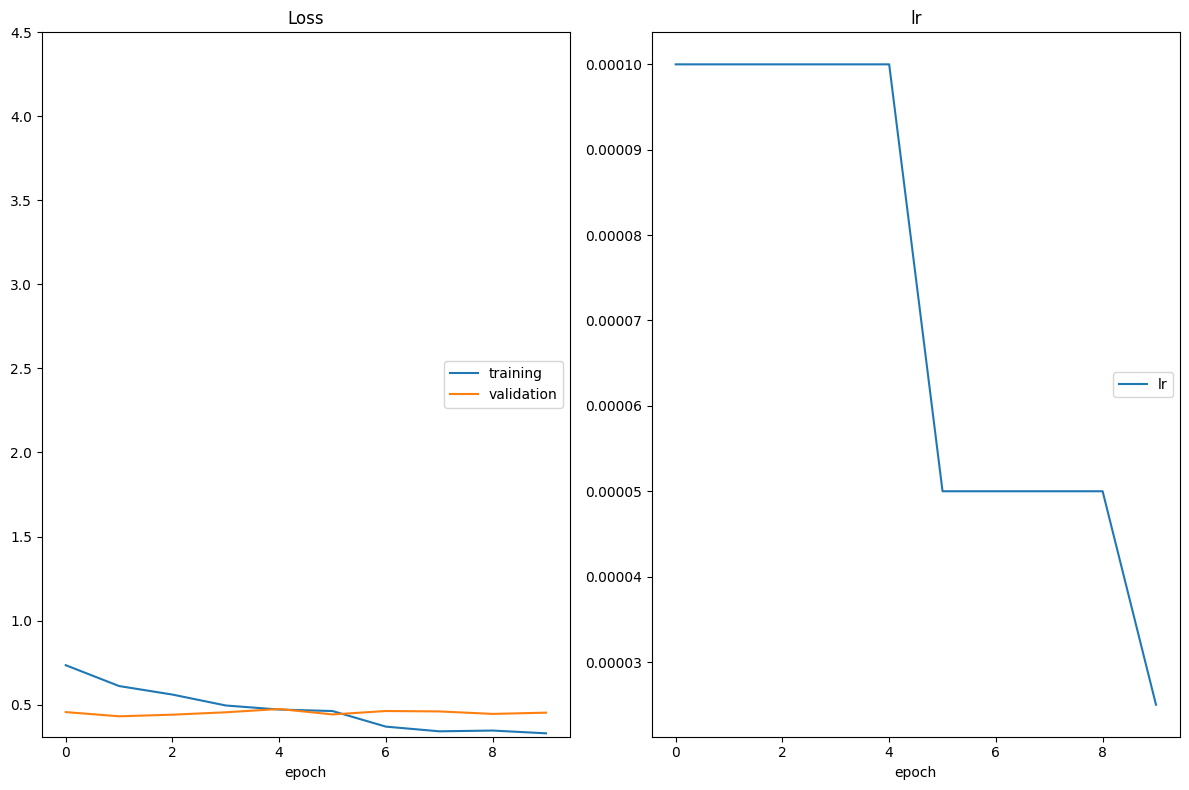

In [6]:
import torch
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning


model_transfer = get_model_transfer_learning('efficientvit_b2.r224_in1k', 50, fine_tune=True)

# load pretrained paramenters 50 epochs, lr 0.0001,increase lr to train another 50 epochs.
model_transfer.load_state_dict(torch.load("model_transfer.pt"))

# train the model
data_loaders = get_data_loaders(batch_size=batch_size, rand_augment_magnitude=9)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, "min",
                                                    factor=.5, patience=3)

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    scheduler,
    loss,
    n_epochs=num_epochs,
    save_path="model_transfer.pt",
    interactive_tracking=True
)

 __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

### Answer:
this time I tried the efficientnet for the transfer model architecture, which is enough complex for learning the features, and trainig speed is much fast. 

in 20 epochs the training losses drop from 2 to 0.8, which is surprising good than the model I have trained early(including resnet, densenet, convnextnano).But, the valid_losses remain unchanged, overfitting expected. adjusting the regularization paramenters train more 10 epochs, the model valid losses drop to .5, but still overfitting.

#### How I deal with overfitting ?
- Use L2 regularization, increase the weight_decay.
- Add more data transforms to augment the data, fine-tune the rand_augment_magnitude

---
Step 3: Test the Model

Try out the model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy. 

In [7]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning('efficientvit_b2.r224_in1k', 50, True)
# Load saved weights
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 40/40 [00:05<00:00,  7.94it/s]

Test Loss: 0.671229


Test Accuracy: 84% (1061/1250)


0.6712287973612546

---
## Step 4: Export using torchscript

Now,  export the best fit model using torchscript so that it can be used in the application:

In [8]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("transfer_exported.pt")

Reusing cached mean and std


In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

100%|███████████████████████████████████████| 1250/1250 [06:26<00:00,  3.23it/s]


Accuracy: 0.8112


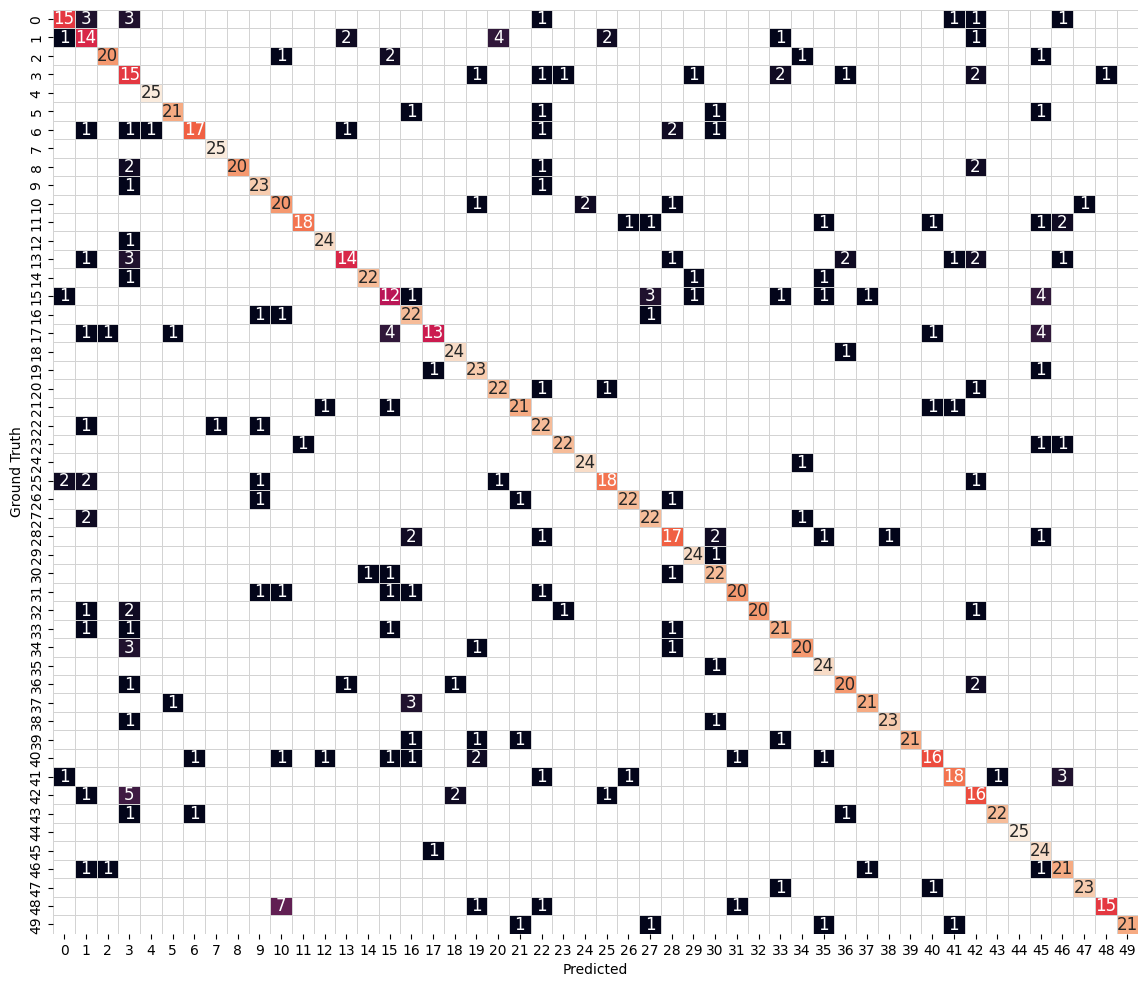

In [12]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)